In [2]:
import numpy as np
import pandas as pd
import rpy2   # Allows Python code to call R functions
import rpy2.robjects   # Provides a high-level interface to access R objects and functions from Python
rpy2.robjects.r['options'](warn=-1)  # Set R global options to suppress warning messages during execution
from rpy2.robjects.packages import importr   # importr: Import R packages into the Python environment
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()  # Activate automatic conversion between numpy and R arrays
importr('RCIT')   # RCIT is an R package for performing conditional and unconditional independence tests
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from contextlib import contextmanager
import statsmodels.api as sm

In [95]:
regression_data = pd.read_csv('../merged_data_sss.csv')
dataset_raw = pd.read_csv('../dataset_raw.csv')
regression_data = regression_data.drop('Unnamed: 0', axis=1)
regression_data.describe()

,gvkey,fyear,month,RET,MOM,BETA,VOLAT,total_emission_scope1,total_emission_scope2,emission_growth_scope1,...,carbon_intensity_scope2,LOGSIZE,B/M,LEVERAGE,INVEST/A,ROE,LOGPPE,SALESGR,EPSGR,RET1
count,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,...,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000,81605.000000
mean,61120.654923,2017.409767,6.522738,1.285111,0.120438,1.195033,0.103849,10.411239,10.627489,0.053134,...,0.314301,8.235747,0.577298,0.275880,0.035363,7.217507,6.841127,0.011243,0.004939,17.425595
std,69006.711553,2.158369,3.451686,12.473213,0.432692,0.727854,0.057046,2.689473,2.067171,0.296586,...,0.381090,1.762027,0.530395,0.215301,0.033117,33.035337,2.093872,0.328364,0.227102,53.736741
min,1004.000000,2011.000000,1.000000,-87.697842,-0.832704,-1.044560,0.025872,0.693147,2.544276,-0.587399,...,0.008185,-4.612195,-0.040954,0.000000,0.000000,-109.224422,-2.465104,-2.260408,-1.598919,-95.067633
25%,10860.000000,2016.000000,4.000000,-4.819277,-0.124580,0.757661,0.063082,8.641213,9.258057,-0.074867,...,0.085381,7.070696,0.230611,0.088988,0.012404,0.751054,5.498769,-0.015899,-0.022173,-9.791332
50%,24783.000000,2018.000000,7.000000,1.053142,0.082349,1.119520,0.090176,10.219274,10.620766,0.025733,...,0.176111,8.231717,0.444195,0.251456,0.025776,10.303030,6.880971,0.021430,0.003362,11.590107
75%,133869.000000,2019.000000,10.000000,6.870229,0.297905,1.546813,0.129241,11.925332,12.018952,0.137206,...,0.377914,9.407562,0.758144,0.412147,0.047656,19.134897,8.165563,0.073998,0.027182,34.970843
max,328795.000000,2020.000000,12.000000,99.191686,3.250000,4.147888,0.356740,18.713283,16.571679,1.124937,...,1.780249,14.627616,2.663034,0.814584,0.163615,91.432361,13.144907,1.647431,1.808117,1042.570281


In [97]:
dataset_raw['SALES'] = dataset_raw.groupby(['gvkey', 'fyear'])['sale'].transform(lambda x: np.log(x))
regression_data = regression_data.merge(dataset_raw[['gvkey', 'fyear', 'SALES']], on=['gvkey', 'fyear'], how='left')

In [98]:
regression_data = regression_data.sort_values(by=['gvkey', 'fyear', 'month'])

columns_to_shift = ['RET', 'MOM', 'BETA', 'VOLAT',
       'total_emission_scope1', 'total_emission_scope2',
       'emission_growth_scope1', 'emission_growth_scope2',
       'carbon_intensity_scope1', 'carbon_intensity_scope2', 'LOGSIZE', 'B/M',
       'LEVERAGE', 'INVEST/A', 'ROE', 'LOGPPE', 'SALESGR', 'EPSGR', 'RET1', 'SALES']

def shift_if_consecutive(group):
    group = group.sort_values(by='datatime')
    
    group['datatime'] = pd.to_datetime(group['datatime'])
    
    # check if data is consecutive on year-month
    group['consecutive'] = group['datatime'].diff().dt.days <= 31
    
    for col in columns_to_shift:
        group[f'{col}_t-1'] = group[col].shift(-1)
        group[f'{col}_t-1'] = group.apply(lambda row: row[col] if not row['consecutive'] else row[f'{col}_t-1'], axis=1)
        group[f'{col}_t+1'] = group[col].shift(+1)
        group[f'{col}_t+1'] = group.apply(lambda row: row[col] if not row['consecutive'] else row[f'{col}_t+1'], axis=1)
    
    return group.drop(columns=['consecutive', 'datatime'])

# apply to each gvkey group
regression_data_shifted = regression_data.groupby('gvkey').apply(shift_if_consecutive)
regression_data_shifted.columns = [col.replace('/', '_') for col in regression_data_shifted.columns]

print(regression_data_shifted.head())

         gvkey  fyear  month       RET       MOM      BETA     VOLAT  \
gvkey                                                                  
1004  0   1004   2017      1 -1.815431  0.433590  1.728236  0.106410   
      1   1004   2017      2  3.790447  0.695722  1.697156  0.106333   
      2   1004   2017      3 -0.148456  0.499601  1.585366  0.106969   
      3   1004   2017      4  7.017544  0.432948  1.536825  0.107289   
      4   1004   2017      5 -3.834398  0.448269  1.553771  0.109533   

         total_emission_scope1  total_emission_scope2  emission_growth_scope1  \
gvkey                                                                           
1004  0              10.991192              10.418976               -0.004909   
      1              10.991192              10.418976               -0.004909   
      2              10.991192              10.418976               -0.004909   
      3              10.991192              10.418976               -0.004909   
      4  

C:\Users\18906\AppData\Local\Temp\ipykernel_27820\3985392856.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regression_data_shifted = regression_data.groupby('gvkey').apply(shift_if_consecutive)


In [99]:
regression_data_shifted = regression_data_shifted.replace([np.inf, -np.inf], np.nan)
regression_data_shifted = regression_data_shifted.dropna()

In [7]:
regression_data_shifted.drop(columns=['GICS Sector Name'], inplace=True)

### RCIT functions

In [8]:
def RCIT(X, x_, y_, z_=None, random_seed=False):
    if random_seed: seed = np.random.choice(1000)
    else: seed = np.random.choice(1000) 
    local_copy = X.copy()
    array = np.array(local_copy.transpose().dropna())
    dim, T = array.shape
    x_vals = array[x_]
    y_vals = array[y_]
    if z_ != None:
        z_vals = array[z_].T.copy()
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, z_vals, seed = seed)
    else:
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, seed = seed)
    return float(rcot.rx2('p')[0])

In [9]:
def RCIT_values(X, x_, y_, z_=None, random_seed=False, n_runs=10):
    
    p_values = []  
    
    for _ in range(n_runs):
        p_value = RCIT(X, x_, y_, z_, random_seed)
        p_values.append(p_value)
    
    return p_values

In [10]:
def cross_sectional_rcit(data, x, y, z, num_subsets):
    subset_size = len(data) // num_subsets
    p_values = []

    for i in range(num_subsets):
        subset = data.iloc[i * subset_size:(i + 1) * subset_size]
        p_value = RCIT(subset, x, y, z)
        p_values.append(p_value)

    return p_values

In [11]:
def chi2_test(p_values, num_bins=10):
    """
    Perform a chi-squared test for uniformity on the given p-values.

    Parameters:
    p_values (list or array): List of p-values to be tested.
    num_bins (int): Number of bins for the histogram. 

    Returns:
    chi2_stat (float): Chi-squared statistic.
    p_val (float): p-value of the uniformity test.
    """
    # Create bins for the histogram
    bins = np.linspace(0, 1, num_bins)
    
    # Calculate observed frequencies
    observed, _ = np.histogram(p_values, bins=bins)
    
    # Calculate expected frequencies
    total_observations = sum(observed)
    num_groups = len(observed)
    expected = [total_observations / num_groups] * num_groups
    
    # Perform chi-squared test
    chi2_stat, p_val = chisquare(observed, expected)
    
    return chi2_stat, p_val

# Example usage
p_values2 = np.random.uniform(0, 2, 1000)  # Example p-values
chi2_stat, p_val = chi2_test(p_values2)

print(f"chi2_stat: {chi2_stat}")
print(f"uniformity p value: {p_val}")

chi2_stat: 4.220472440944882
uniformity p value: 0.8367038584701809


In [12]:
def graph(p_values):

    # Plotting the histogram of p-values
    plt.figure(figsize=(5,3))
    plt.hist(p_values, bins=50, color='blue', alpha=0.6, label='RCIT p-values')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [13]:
def graph2(p_values1, p_values2):
    # Plotting the histogram of p-values
    plt.figure(figsize=(5,3))
    plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
    plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Conditional Independence Tests
#### 1.2. Determinants for Emissions

LOGSIZE_t0 ⊥ RET_t1 | B/M_t0, Emissions, INVEST/A, LEVERAGE, LOGPPE_t0, ROE, SALES

In [84]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('LOGSIZE_t-1')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('total_emission_scope1'), regression_data_shifted.columns.get_loc('B_M_t-1'),\
     regression_data_shifted.columns.get_loc('ROE')]

In [94]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 100)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.32695473419802085
uniformity test p-value (conditional): 0.007130618236415638
average p value (unconditional): 0.262752706534065
uniformity test p-value (unconditional): 9.687186474991967e-19


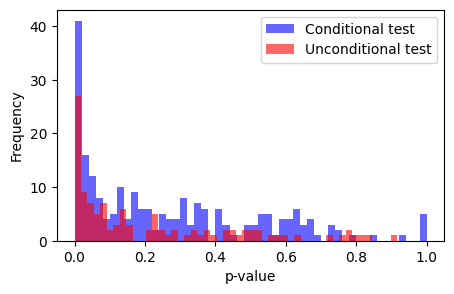

In [34]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

LOGPPE_t0 ⊥ RET_t1 | B/M_t0, Emissions, INVEST/A, LEVERAGE, LOGSIZE_t0, SALES

In [35]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('LOGPPE_t-1')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('INVEST_A'),  \
     regression_data_shifted.columns.get_loc('total_emission_scope1'), regression_data_shifted.columns.get_loc('B_M_t-1'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [36]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.2607853569899962
uniformity test p-value (conditional): 9.541376556723333e-150
average p value (unconditional): 0.2406043034551039
uniformity test p-value (unconditional): 3.9265287694154425e-56


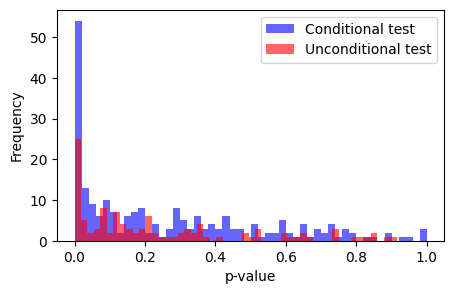

In [37]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

B/M_t0 ⊥ RET_t1 | INVEST/A, LEVERAGE, LOGPPE_t0, LOGSIZE_t0

In [79]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('B_M_t-1')
z = [regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('INVEST_A'),  \
     regression_data_shifted.columns.get_loc('LOGPPE_t-1'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [83]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=200)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 100)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.24611688417473324
uniformity test p-value (conditional): 1.0996553091860977e-94
average p value (unconditional): 0.24750082555482933
uniformity test p-value (unconditional): 5.191039652069086e-50


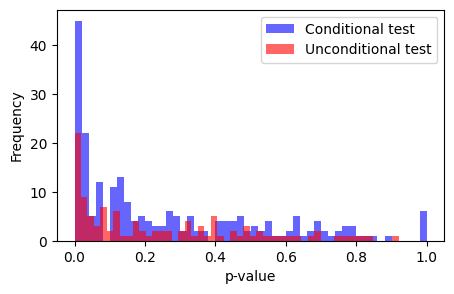

In [40]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

INVEST/A ⊥ RET_t1 | B/M_t0, Emissions, LEVERAGE, LOGPPE_t0, LOGSIZE_t0, SALES

In [41]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('INVEST_A')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('LOGPPE_t-1'),  \
     regression_data_shifted.columns.get_loc('total_emission_scope1'), regression_data_shifted.columns.get_loc('B_M_t-1'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [42]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.26330707787194024
uniformity test p-value (conditional): 2.214095396764971e-213
average p value (unconditional): 0.28448825424041896
uniformity test p-value (unconditional): 6.689715819227898e-35


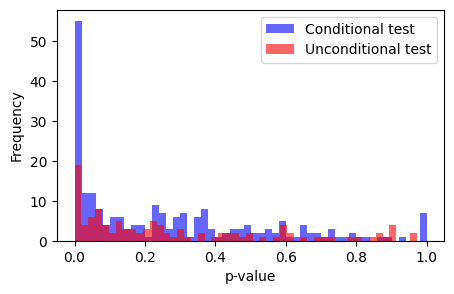

In [43]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

RET_t1 ⊥ SALES | Emissions, INVEST/A, LEVERAGE, LOGPPE_t0, LOGSIZE_t0, ROE

In [44]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('SALES')
z = [regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LEVERAGE'),\
     regression_data_shifted.columns.get_loc('LOGPPE_t-1'),  \
     regression_data_shifted.columns.get_loc('total_emission_scope1'), regression_data_shifted.columns.get_loc('ROE'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [45]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.25064426910923454
uniformity test p-value (conditional): 7.917463555516307e-111
average p value (unconditional): 0.23332570146280668
uniformity test p-value (unconditional): 9.66690277190132e-64


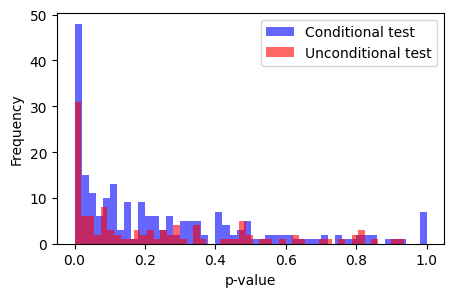

In [46]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

RET_t1 ⊥ ROE | EPSGR, LOGSIZE_t0, SALES

In [47]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('ROE')
z = [regression_data_shifted.columns.get_loc('EPSGR'), regression_data_shifted.columns.get_loc('SALES'),\
     regression_data_shifted.columns.get_loc('LOGSIZE_t-1')]

In [48]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.23230070094356436
uniformity test p-value (conditional): 5.968748327918951e-186
average p value (unconditional): 0.2084104438046297
uniformity test p-value (unconditional): 3.04295494176922e-27


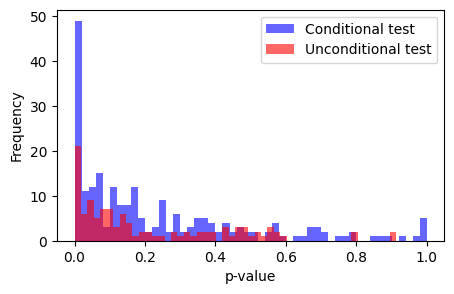

In [49]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

EPSGR ⊥ RET_t1 | ROE

In [75]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('EPSGR')
z = [regression_data_shifted.columns.get_loc('ROE')]

In [78]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=100)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.35320642458983154
uniformity test p-value (conditional): 0.08144728134904429
average p value (unconditional): 0.27186971721368386
uniformity test p-value (unconditional): 2.535319562621752e-07


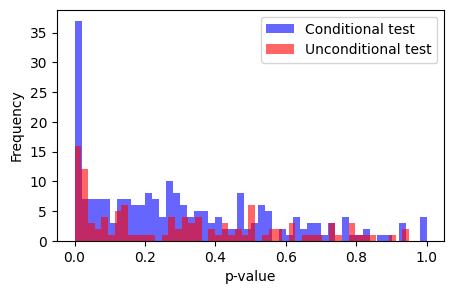

In [52]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

RET_t1 ⊥ VOLAT | LEVERAGE

In [56]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('VOLAT')
z = [regression_data_shifted.columns.get_loc('LEVERAGE')]

In [57]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.02590557009635281
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.005278175555050193
uniformity test p-value (unconditional): 0.0


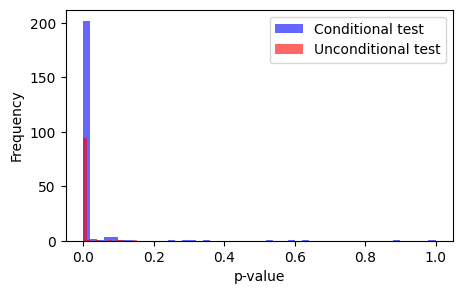

In [58]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=13, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

RET_t1 ⊥ VOLAT_t1 | LEVERAGE 

In [25]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('total_emission_scope1')
y = regression_data_shifted.columns.get_loc('VOLAT_t+1')
z = [regression_data_shifted.columns.get_loc('LEVERAGE')]

In [26]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=100)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.019820549981899832
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.006090845471693066
uniformity test p-value (unconditional): 0.0


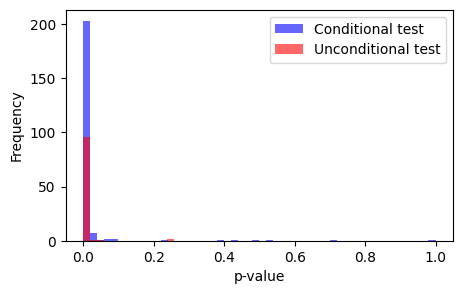

In [30]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=13, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

LEVERAGE ⊥ RET_t1 | B/M_t0, Emissions, INVEST/A, LOGPPE_t0, LOGSIZE_t0, SALES, VOLAT

In [53]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('LEVERAGE')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('total_emission_scope1'), regression_data_shifted.columns.get_loc('B_M_t-1'),\
     regression_data_shifted.columns.get_loc('VOLAT')]

In [54]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.1095153920285687
uniformity test p-value (conditional): 0.0
average p value (unconditional): 0.26945474928968444
uniformity test p-value (unconditional): 8.499838656330194e-28


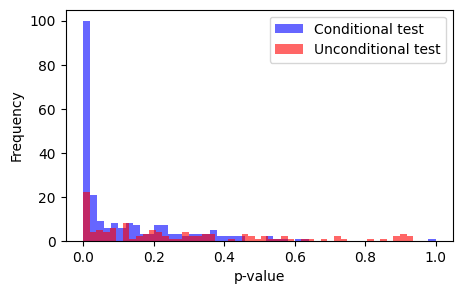

In [55]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Emissions - RET_t1

Emissions ⊥ RET_t1 | INVEST/A, LEVERAGE, LOGPPE_t0, LOGSIZE_t0, SALES

In [59]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('total_emission_scope1')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('LEVERAGE')]

In [60]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.2371589289365799
uniformity test p-value (conditional): 7.873096084663164e-117
average p value (unconditional): 0.23235306186922863
uniformity test p-value (unconditional): 1.4862600304643667e-60


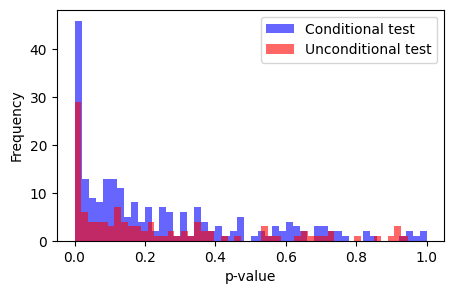

In [61]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [62]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('total_emission_scope2')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('LEVERAGE')]

In [63]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.2491991366663568
uniformity test p-value (conditional): 1.9562055593514322e-106
average p value (unconditional): 0.2633997401595454
uniformity test p-value (unconditional): 3.926528769415329e-56


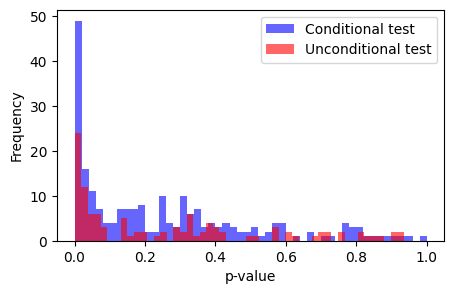

In [64]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [71]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('emission_growth_scope1')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('LEVERAGE')]

In [74]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

average p value (conditional): 0.24448869009986524
uniformity test p-value (conditional): 6.823973368308483e-206


In [73]:
# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (unconditional): 0.34400239330841553
uniformity test p-value (unconditional): 0.052098613246567255


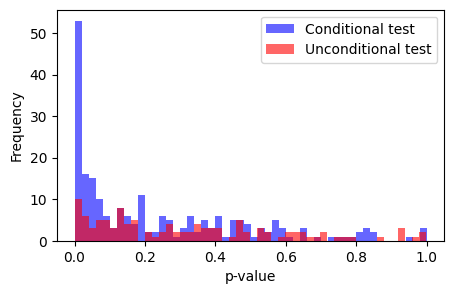

In [67]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [68]:
X = regression_data_shifted  

x = regression_data_shifted.columns.get_loc('RET_t+1')
y = regression_data_shifted.columns.get_loc('emission_growth_scope2')
z = [regression_data_shifted.columns.get_loc('SALES'), regression_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
     regression_data_shifted.columns.get_loc('INVEST_A'), regression_data_shifted.columns.get_loc('LOGPPE_t-1'), \
     regression_data_shifted.columns.get_loc('LEVERAGE')]

In [69]:
# run conditional independence tests
p_values1 = cross_sectional_rcit(X, x, y, z, num_subsets=222)
p_mean = np.average(p_values1)
print(f"average p value (conditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values1, 200)
print(f"uniformity test p-value (conditional): {p_value}")

# run unconditional independence tests
p_values2 = cross_sectional_rcit(X, x, y, z=None, num_subsets=111)
p_mean = np.average(p_values2)
print(f"average p value (unconditional): {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values2, 100)
print(f"uniformity test p-value (unconditional): {p_value}")

average p value (conditional): 0.23013518368291452
uniformity test p-value (conditional): 6.08748228099027e-109
average p value (unconditional): 0.33754461641833516
uniformity test p-value (unconditional): 2.9375249487358743e-05


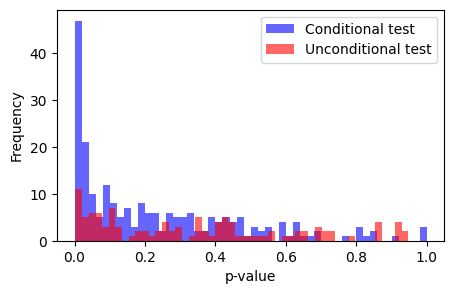

In [70]:
plt.figure(figsize=(5,3))
plt.hist(p_values1, bins=50, color='blue', alpha=0.6, label='Conditional test')
plt.hist(p_values2, bins=50, color='red', alpha=0.6, label='Unconditional test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()